import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
The goal of this notebook is to **Process Google's GTFS Data.** I will use this data to:
- find out how many trains are operating in the NYC Subway at any given time (284 -- no SIR)
- find the most used stations in the network
- find the ridership per train of each station in the network
- find the trains per hour for each line/station in the network

More info about [GTFS Data](https://gtfs.org) in general. There are two types: 
- schedule data 
- real time data [extra information about this](https://doodles.patrickweaver.net/working-with-nyc-mta-realtime-subway-data/slides/4/)

I don't notice any difference between the two. I'll just use schedule data

[MTA Developer Tools](https://new.mta.info/developers). The google data for the mta should be all that we need. There's weekday, saturday, and sunday service so only need to worry about those times. Additionally, there's data on the buses, LIRR and Metro North in there, too.
- [mta metrics dashboard](https://metrics.mta.info/?subway/customerjourneytimeperformance)

- (slightly outdated) [time frequency](https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_services#Train_frequency_charts) breakdown
- [service update statistics](https://subwaystats.com). Shows how on-time a train is the in the past 30 days
- [an attempt](https://www.quora.com/How-many-trains-are-on-a-New-York-subway-line-at-any-given-time) at answering the question "How many trains are currently running in the subway"

[The project](https://tyleragreen.com/maps/new_york/) that inspired this one. [General Subway trivia](https://www.nycsubway.org/wiki/Main_Page)

Some notes about the results:
- the routes change by day of week (for example the M not running its whole route on the weekends)
- some routes include service changes (the 7 and 7 express both count as the 7)
- this also includes late nights where the routes can change dramatically (e.g.: the 5 train doesn't leave the BX at night)
- two routes don't run on the weekends: the B and W

# Imports

In [27]:
import pandas as pd
import numpy as np
import geopandas
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings(action='once')

## Functions 

In [28]:
def determine_train_time_intervals(arrival_time, day_of_week: str):
    arrival_time = arrival_time.time()
    train_time_interval = None
    if datetime.time(0, 0) <= arrival_time < datetime.time(6, 30):
        train_time_interval = 'Late Night'
    elif day_of_week in ['Saturday', 'Sunday']:
        train_time_interval = 'Weekend'
    elif datetime.time(6, 30) <= arrival_time < datetime.time(9, 30):
        train_time_interval = 'Rush Hour AM'
    elif datetime.time(9, 30) <= arrival_time < datetime.time(15, 30):
        train_time_interval = 'Midday'
    elif datetime.time(15, 30) <= arrival_time < datetime.time(20, 0):
        train_time_interval = 'Rush Hour PM'
    elif datetime.time(20, 0) <= arrival_time <= datetime.time(23, 59):
        train_time_interval = 'Evening'
    return train_time_interval

def scale_time_intervals_to_hour(df_grouped_at_interval_level: pd.DataFrame):
    for idx, row in df_grouped_at_interval_level.iterrows():
        if row['train_time_interval'] == 'Late Night':
            new_tph = (row['trains_per_hour'] / 3) / 6.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Weekend':
            new_tph = (row['trains_per_hour'] / 2) / 17.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour AM':
            new_tph = row['trains_per_hour'] / 3 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Midday':
            new_tph = row['trains_per_hour'] / 6 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Rush Hour PM':
            new_tph = row['trains_per_hour'] / 4.5 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
        elif row['train_time_interval'] == 'Evening':
            new_tph = row['trains_per_hour'] / 4 # multiply by days ratio and hours ratio 
            df_grouped_at_interval_level.at[idx, 'trains_per_hour'] = new_tph
    return df_grouped_at_interval_level

def group_into_day_type(dataframe: pd.DataFrame, column_name:str):    
    day_of_week_list = []
    for x in dataframe[column_name]:
        if 'Weekday' in x or 'L0S1' in x:
            day_of_week_list.append('Weekday')
        elif 'Saturday' in x or 'L0S2' in x:
            day_of_week_list.append('Saturday')
        elif 'Sunday' in x or 'L0S3' in x:
            day_of_week_list.append('Sunday')
    dataframe['day_of_week'] = day_of_week_list
    return dataframe

## Real Time Data

In [4]:
trips_supplemented_df = pd.read_csv("data/google_transit_supplemented/trips.txt")
stops_df_supplemented = pd.read_csv("data/google_transit_supplemented/stops.txt")

## Schedule Data

In [80]:
# holdays and other days when the data would be different than expected
calendar_dates_df = pd.read_csv("data/google_transit/calendar_dates.txt") 
calendar_df = pd.read_csv("data/google_transit/calendar.txt")
routes_df = pd.read_csv("data/google_transit/routes.txt")
stop_times_df = pd.read_csv("data/google_transit/stop_times.txt")
stops_df = pd.read_csv("data/google_transit/stops.txt")
transfers_df = pd.read_csv("data/google_transit/transfers.txt")
trips_df = pd.read_csv("data/google_transit/trips.txt")
# not useful data 
# agency_df = pd.read_csv("google_transit/agency.txt")
shapes_df = pd.read_csv("data/google_transit/shapes.txt")

In [30]:
all_dfs_list = [calendar_dates_df, calendar_df, routes_df, shapes_df
               , stop_times_df, stops_df, transfers_df, trips_df]

## Other Data

In [31]:
# hourly ridership from 2024-1-8 -- 2024-1-14
# https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-February-202/wujg-7c2s/explore/query/SELECT%0A%20%20%60transit_timestamp%60%2C%0A%20%20%60transit_mode%60%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60ridership%60%0AWHERE%0A%20%20caseless_one_of%28%60transit_mode%60%2C%20%22staten_island_railway%22%2C%20%22subway%22%29%0A%20%20AND%20%28%60transit_timestamp%60%0A%20%20%20%20%20%20%20%20%20BETWEEN%20%222024-01-08T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20%20%20%20%20AND%20%222024-01-15T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%29%0AORDER%20BY%20%60transit_timestamp%60%20ASC%20NULL%20LAST/page/filter
original_hourly_station_ridership = pd.read_csv("data/MTA_Subway_Hourly_Ridership__Beginning_February_2022_20240121.csv")
# All Staten Island data is assigned to one station so I need to remove it
original_hourly_station_ridership = original_hourly_station_ridership[original_hourly_station_ridership
                                                                      ['transit_mode']=='subway']
hourly_station_ridership = original_hourly_station_ridership.groupby(
                                ['station_complex_id', 'transit_timestamp']).sum().reset_index()

In [32]:
hourly_station_ridership['time_as_datetime'] = pd.to_datetime(hourly_station_ridership['transit_timestamp']
                                                          , errors='coerce')

In [81]:
# https://catalog.data.gov/dataset/mta-subway-stations-and-complexes
stations_info_df = pd.read_csv("data/MTA_Subway_Stations_and_Complexes.csv")
stations_info_df = stations_info_df.drop(columns=['ADA', 'ADA Notes'])
# making this easier to explode later
stations_info_df['GTFS_Stop_IDs_Listed'] = [x if ";" not in x else list(x.replace(" ", "").replace(";", ",")
                                                                        .split(",")) 
                                            for x in stations_info_df['GTFS Stop IDs']]

In [34]:
stations_info_df_exploded = stations_info_df.explode("GTFS_Stop_IDs_Listed")

# Adjustments to the GTFS Dfs

## Date Format

In [35]:
# calendar_dates_df['date'].astype('datetime')
calendar_dates_df['date'] = pd.to_datetime(calendar_dates_df['date'], format="%Y%m%d")

In [36]:
calendar_df['start_date'] = pd.to_datetime(calendar_df['start_date'], format="%Y%m%d")
calendar_df['end_date'] = pd.to_datetime(calendar_df['end_date'], format="%Y%m%d")

In [82]:
#making the times within a 24 hour range -- up to 27 
stop_times_df['arrival_time'] = [str(int(x[0:2]) - 24) + x[2:] if int(x[0:2]) >= 24 else x
                          for x in stop_times_df['arrival_time']]
stop_times_df['departure_time']  = [str(int(x[0:2]) - 24) + x[2:] if int(x[0:2]) >= 24 else x
                          for x in stop_times_df['departure_time']]
# making to a datetime
stop_times_df['arrival_time'] = pd.to_datetime(stop_times_df['arrival_time'], format="%H:%M:%S"
                                                  , errors='coerce')
stop_times_df['departure_time'] = pd.to_datetime(stop_times_df['departure_time'], format="%H:%M:%S"
                                                    , errors='coerce')

In [83]:
stop_times_df = group_into_day_type(stop_times_df, 'trip_id')

## Removing Some of the data

In [39]:
# removing lat lon data
# shapes_df.drop(columns=['shape_pt_lat', 'shape_pt_lon'], inplace=True)
stops_df.drop(columns=['stop_lat', 'stop_lon'], inplace=True)
stop_times_df = stop_times_df[~stop_times_df['arrival_time'].isnull()]

## Exploring the data

In [40]:
# calendar_dates_df.head()
# calendar_df.head()
# routes_df[routes_df['route_short_name']=='W']['route_desc'].values

In [41]:
# all of the trips
stop_times_df.head(2)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,day_of_week
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1,Sunday
1,AFA23GEN-1038-Sunday-00_000600_1..S03R,103S,1900-01-01 00:07:30,1900-01-01 00:07:30,2,Sunday


In [42]:
transfers_df.head(2)

,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,101,101,2,180
1,103,103,2,180


In [43]:
# route_id is the short_route_name (Z train is lumped together with the J train for trips ids)
trips_df.head(2)

,route_id,trip_id,service_id,trip_headsign,direction_id,shape_id
0,1,AFA23GEN-1038-Sunday-00_000600_1..S03R,Sunday,South Ferry,1,1..S03R
1,1,AFA23GEN-1038-Sunday-00_002600_1..S03R,Sunday,South Ferry,1,1..S03R


In [44]:
trips_df.shape

(20365, 6)

In [45]:
# get the memory usage of each table in KB
# for df in all_dfs_list:
#     print(f"{df.memory_usage().sum()/1000}")
# shapes_df and stop_times are the larger tables
# I halved the memory usage by removing the lat and lon data in 2 tables

## Finding Beginning of Each Route
Using Stop Times df

In [46]:
first_stop_in_trip = stop_times_df[stop_times_df['stop_sequence']==1]
first_stop_in_trip['departure_hour'] = first_stop_in_trip['departure_time'].dt.hour
first_stop_in_trip['route_id'] = [x.split("_")[-1].split('.')[0] 
                                        for x in first_stop_in_trip['trip_id']]
first_stop_in_trip['shape_id'] = [x.split("_")[-1] for x in first_stop_in_trip['trip_id']]
first_stop_in_trip = first_stop_in_trip[~first_stop_in_trip.arrival_time.isnull()]

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
# first_stop_in_trip[first_stop_in_trip['shape_id'].isnull()]
first_stop_in_trip.head(2)

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,day_of_week,departure_hour,route_id,shape_id
0,AFA23GEN-1038-Sunday-00_000600_1..S03R,101S,1900-01-01 00:06:00,1900-01-01 00:06:00,1,Sunday,0,1,1..S03R
38,AFA23GEN-1038-Sunday-00_002600_1..S03R,101S,1900-01-01 00:26:00,1900-01-01 00:26:00,1,Sunday,0,1,1..S03R


In [48]:
# Making the data be "per direction" (closer to how an average person would think interpret this)
# the shuttles only have 1 "." -- very close to 50:50 (50.6 ~ 49.4)
directions = []
for x in first_stop_in_trip['shape_id']:
    direction = x.split(".", 1)[1]
    if "S" in direction:
        directions.append("S")
    else:
        directions.append("N")
first_stop_in_trip['direction'] = directions
first_stop_in_trip = first_stop_in_trip[first_stop_in_trip['direction'] == 'S']

### By Day

In [49]:
first_stop_in_trip_per_day = pd.DataFrame(first_stop_in_trip.groupby(
                                                ['route_id', 'day_of_week']
                                                ).size() / 24).reset_index()
first_stop_in_trip_per_day.columns = ['route_id', 'day_of_week', 'trains_per_hour']
first_stop_in_trip_per_day['headway_seconds'] = round(3600 / first_stop_in_trip_per_day['trains_per_hour'])
first_stop_in_trip_per_day['headway_minutes'] = round(60 / first_stop_in_trip_per_day['trains_per_hour'], 1)

### By Hour

In [50]:
# freq by hour for all routes and all days on schedule 
route_trip_freq_by_hour = first_stop_in_trip.groupby(['route_id', 'day_of_week', 'departure_hour']).sum()

In [51]:
route_trip_freq_by_hour.columns = ['trains_per_hour']
route_trip_freq_by_hour['headway_seconds'] = round(3600 / route_trip_freq_by_hour['trains_per_hour'])
route_trip_freq_by_hour['headway_minutes'] = round(60 / route_trip_freq_by_hour['trains_per_hour'], 1)

### Overall

In [290]:
# avg daily freq all routes 
route_trip_freq_overall_by_hour = route_trip_freq_by_hour['trains_per_hour'].unstack(level=1)
route_trip_freq_overall_by_hour.fillna(value=0, inplace=True) # needed b/c there's no weekend B trains
route_trip_freq_overall_by_hour['Weekday_Adjusted'] = round(route_trip_freq_overall_by_hour['Weekday'] * 5, 2)
route_trip_freq_overall_by_hour['Hourly_tph'] = route_trip_freq_overall_by_hour['Weekday_Adjusted'] + \
                                                route_trip_freq_overall_by_hour['Saturday'] + \
                                                route_trip_freq_overall_by_hour['Sunday']

In [292]:
route_trip_freq_overall_by_day = round(route_trip_freq_overall_by_hour.groupby(['route_id']).sum() / 24, 2)
route_trip_freq_overall_by_day.columns = ['Saturday', 'Sunday', 'Weekday'
                                          , 'Weekday_Adjusted', 'Total_trains_per_day']
route_trip_freq_overall_by_day['Trains_per_Hour_Overall'] = round(route_trip_freq_overall_by_day \
                                                                  ['Total_trains_per_day'] / 7, 1)
# the wait time is half of the mean time between trains
route_trip_freq_overall_by_day['headway_minutes'] = round(60 / \
                                                    route_trip_freq_overall_by_day['Trains_per_Hour_Overall'], 1)

In [294]:
# route_trip_freq_overall_by_day.sort_values(by='Trains_per_Hour_Overall')

### By Train Time Interval

In [55]:
train_time_interval_list = []
for idx, row in first_stop_in_trip.iterrows():
    train_time_interval = determine_train_time_intervals(row['arrival_time'], row['day_of_week'])
    train_time_interval_list.append(train_time_interval)
first_stop_in_trip['train_time_interval'] = train_time_interval_list

In [56]:
first_stop_in_trip_per_interval = pd.DataFrame(first_stop_in_trip.groupby(
                                                ['route_id', 'train_time_interval']
                                                ).size()).reset_index()
first_stop_in_trip_per_interval.columns = ['route_id', 'train_time_interval', 'trains_per_hour']
first_stop_in_trip_per_interval = scale_time_intervals_to_hour(first_stop_in_trip_per_interval)
first_stop_in_trip_per_interval['headway_seconds'] = round(3600 / first_stop_in_trip_per_interval['trains_per_hour'])
first_stop_in_trip_per_interval['headway_minutes'] = round(60 / first_stop_in_trip_per_interval['trains_per_hour'], 1)

### Data Viz

In [59]:
# I wasn't too far off when I said "the L on it's worse day is better than the G on it's best day"
# first_stop_in_trip_per_day[first_stop_in_trip_per_day['route_id'].isin(['L', 'G'])]
first_stop_in_trip_per_day[first_stop_in_trip_per_day['route_id'].isin(['L', '7', '6'])]

,route_id,day_of_week,trains_per_hour,headway_seconds,headway_minutes
15,6,Saturday,7.291667,494.0,8.2
16,6,Sunday,6.416667,561.0,9.4
17,6,Weekday,11.500000,313.0,5.2
18,7,Saturday,9.375000,384.0,6.4
19,7,Sunday,7.541667,477.0,8.0
20,7,Weekday,13.375000,269.0,4.5
52,L,Saturday,10.375000,347.0,5.8
53,L,Sunday,9.291667,387.0,6.5
54,L,Weekday,11.375000,316.0,5.3


What's the ratio between weekday service and sunday service? AKA, how much do the trains vary by day of week?

##### Viewing the Data Visually

In [62]:
# getting the order of best performers (on weekday performance)
sorted_routes = first_stop_in_trip_per_day[first_stop_in_trip_per_day
                                 ['day_of_week']=='Weekday'].sort_values(by='trains_per_hour')['route_id'].values

<AxesSubplot:xlabel='route_id', ylabel='headway_minutes'>

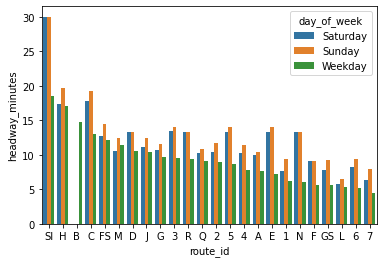

In [63]:
sns.barplot(data=first_stop_in_trip_per_day, x='route_id'
           , y='headway_minutes', hue='day_of_week', order=sorted_routes)

### Manipulating stop_times using shape_id

In [428]:
# select the min and max stop number for each route 
# max stop sequence for each trip 
# stop_times_df['trip_id'].nunique()

In [429]:
# unique_trips_w_stop_seq = pd.DataFrame(stop_times_df.groupby('trip_id').max()['stop_sequence'].reset_index())
# unique_trips_w_stop_seq['route_id'] = [x.split("_")[-1].split('.')[0] for x in unique_trips_w_stop_seq['trip_id']]
# unique_trips_w_stop_seq['shape_id'] = [x.split("_")[-1] for x in unique_trips_w_stop_seq['trip_id']]
# unique_trips_w_stop_seq.head()

In [430]:
# route_trip_max_stop = unique_trips_w_stop_seq.groupby(['shape_id']).max().reset_index()

### Can I deconstruct the trip_id?

In [431]:
# route_trip_max_stop['trip_id'].str.count("_").unique()
# route_trip_max_stop['trip_id'].str.count("-").unique() # only SIR has 4 dashes

In [432]:
# all_first_values = [] # I think this has to do with the train set (A div or B div)
# all_second_values = [] # I think this has something to do with the (long) route id
# for trip in route_trip_max_stop['trip_id']:
#     values_list = trip.split("-")
#     if values_list[0] not in all_first_values:
#         all_first_values.append(values_list[0])
#     if values_list[1] not in all_second_values:
#         all_second_values.append(values_list[1])

### Finding mean trip time by service 

In [187]:
# no trip is longer than 2 hours so I'll drop anything larger than that (the late night trains fuck up the timing)
trip_time_diff = stop_times_df.groupby('trip_id')['departure_time'].agg(np.ptp)
trip_time_diff.mean()

Timedelta('0 days 01:25:06.256322121')

In [206]:
# 97.6% of all trips
valid_trip_times = pd.DataFrame(trip_time_diff[trip_time_diff.values<pd.Timedelta('0 days 02:00:00')]).reset_index()

valid_trip_times['route_id'] = [x.split("_")[-1].split('.')[0] 
                                        for x in valid_trip_times['trip_id']]

In [253]:
# the F and the A have the longest trip times
# valid_trip_times.sort_values(by='departure_time', ascending=False)[0:6]
# the longest trip
# stop_times_df[stop_times_df['trip_id']=='L0S1-F-1077-S04_065800_F..S53X012']

In [242]:
avg_trip_time = pd.DataFrame(valid_trip_times.groupby('route_id').mean(numeric_only=False)).reset_index()
avg_trip_time['route_time_seconds'] = [round(x.total_seconds()) for x in avg_trip_time['departure_time']]
avg_trip_time['route_time_minutes'] = [round(x / 60, 1) for x in avg_trip_time['route_time_seconds']]

In [249]:
avg_trip_time_final = avg_trip_time.drop(columns='departure_time')

#### Adding to Daily Frequency Table 

In [271]:
daily_route_trip_freq = route_trip_freq_overall_by_day.merge(avg_trip_time_final, on='route_id')

In [277]:
daily_route_trip_freq['Avg_num_trains_running'] = round((daily_route_trip_freq['route_time_minutes'] / 60) * \
                                        daily_route_trip_freq['Trains_per_Hour_Overall'], 1)

In [278]:
daily_route_trip_freq

,route_id,Saturday,Sunday,Weekday,Weekday_Adjusted,Total_trains_per_day,Trains_per_Hour_Overall,headway_minutes,route_time_seconds,route_time_minutes,Avg_num_trains_running
0,1,7.750000,6.416667,9.625000,48.125000,62.291667,8.9,6.7,3408,56.8,8.4
1,2,5.791667,5.125000,6.750000,33.750000,44.666667,6.4,9.4,5744,95.7,10.2
2,3,4.458333,4.250000,6.333333,31.666667,40.375000,5.8,10.3,3461,57.7,5.6
3,4,5.875000,5.250000,7.708333,38.541667,49.666667,7.1,8.5,4141,69.0,8.2
4,5,4.500000,4.291667,6.875000,34.375000,43.166667,6.2,9.7,3317,55.3,5.7
5,6,7.291667,6.416667,11.500000,57.500000,71.208333,10.2,5.9,3445,57.4,9.8
6,7,9.375000,7.541667,13.375000,66.875000,83.791667,12.0,5.0,2245,37.4,7.5
7,A,6.000000,5.791667,7.875000,39.375000,51.166667,7.3,8.2,4850,80.8,9.8
8,B,0.000000,0.000000,4.083333,20.416667,20.416667,2.9,20.7,4303,71.7,3.5
9,C,3.375000,3.125000,4.625000,23.125000,29.625000,4.2,14.3,4079,68.0,4.8


## Creating the Lines

In [ ]:
## I just need to connect stations and have accompanying information

In [66]:
shapes_df['lat_lon'] = list(zip(round(shapes_df['shape_pt_lat'], 6), round(shapes_df['shape_pt_lon'], 6)))

In [67]:
# less than half as many rows now
shapes_df_unique = shapes_df[shapes_df['shape_id'].str.contains(".S")]

shape_route_dict = dict(zip(trips_df['shape_id'], trips_df['route_id']))
shapes_df_unique['route_id'] = shapes_df_unique['shape_id'].replace(shape_route_dict)

shapes_df_unique['route_id_len'] = [len(x) for x in shapes_df_unique['route_id']]
# removing shapes that aren't in the current dataset 
shapes_df_unique = shapes_df_unique[shapes_df_unique['route_id_len'] <= 2]

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## Station (Complex) Data

### Grouping at Station Complex Level

In [129]:
# I can find the lines that connect each station
## I would need to further combine them to equal the service pattern
parent_stops_df = stops_df_supplemented[stops_df_supplemented['parent_station'].isnull()==True]
parent_stops_df['lat_lon'] = list(zip(round(parent_stops_df['stop_lat'], 6)
                                      , round(parent_stops_df['stop_lon'], 6)))

/Users/gregfeliu/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [130]:
stop_times_df['route_id'] = [x.split("_")[-1].split('.')[0] 
                                        for x in stop_times_df['trip_id']]
stop_times_df['parent_stop_id'] = [x[0:-1] for x in stop_times_df['stop_id']]

In [131]:
# I'll need to group each segment (between stations)
# identify which lines use that segment
# add up the number of trains that use that segment 
# scale the width of that segment to the number of trains per hour 

In [132]:
train_time_interval_list = []
for idx, row in stop_times_df.iterrows():
    train_time_interval = determine_train_time_intervals(row['arrival_time'], row['day_of_week'])
    train_time_interval_list.append(train_time_interval)
stop_times_df['train_time_interval'] = train_time_interval_list

In [133]:
# trains per hour during weekdays 
# this includes both directions so I'm dividing by 2 to make it "per direction"
trains_per_weekday_hour_by_station = round(stop_times_df[stop_times_df['day_of_week'] == 'Weekday'
                                                  ].groupby('parent_stop_id').count() / 24 / 2, 2)[['trip_id']]
trains_per_weekday_hour_by_station.reset_index(inplace=True)

In [134]:
trains_per_weekday_hour_by_complex = trains_per_weekday_hour_by_station.merge(
                                right=stations_info_df_exploded[['Complex ID', 'GTFS_Stop_IDs_Listed', ]]
                                , how='outer', left_on='parent_stop_id', right_on='GTFS_Stop_IDs_Listed')
trains_per_weekday_hour_by_complex = trains_per_weekday_hour_by_complex.groupby('Complex ID').sum().reset_index()

In [135]:
trains_per_weekday_hour_by_complex_all_info = trains_per_weekday_hour_by_complex.merge(stations_info_df_exploded.drop(columns="Is Complex")
                                                              , how='outer')
trains_per_weekday_hour_by_complex_all_info.drop_duplicates(subset='Complex ID', inplace=True)

In [138]:
trains_per_weekday_hour_by_complex_all_info.columns = ['Complex ID', 'tph', 'Number Of Stations In Complex'
                                                       , 'Stop Name',
                                               'Display Name', 'Constituent Station Names', 'Station IDs',
                                               'GTFS Stop IDs', 'Borough', 'Daytime Routes', 'Structure Type',
                                               'Latitude', 'Longitude', 'GTFS_Stop_IDs_Listed']

In [139]:
trains_per_weekday_hour_by_complex_all_info.sort_values(by='tph', ascending=False)[0:3]

,Complex ID,tph,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,Daytime Routes,Structure Type,Latitude,Longitude,GTFS_Stop_IDs_Listed
440,611,88.59,5,Times Sq-42 St/Port Authority Bus Terminal,Times Sq-42 St/Port Authority Bus Terminal (1 ...,42 St-Port Authority Bus Terminal; Times Sq-42 St,11; 163; 317; 467; 468,127; 725; 902; A27; R16,M,1 2 3 7 A C E N Q R W S,Subway,40.755746,-73.987581,127
419,602,58.22,3,14 St-Union Sq,14 St-Union Sq (4 5 6 L N Q R W),14 St-Union Sq,15; 117; 406,635; L03; R20,M,4 5 6 L N Q R W,Subway,40.735066,-73.990416,635
455,617,53.46,3,Atlantic Av-Barclays Ctr,Atlantic Av-Barclays Ctr (2 3 4 5 B D N Q R),Atlantic Av-Barclays Ctr,27; 40; 338,235; D24; R31,Bk,2 3 4 5 B D N Q R,Subway,40.684162,-73.977789,235


In [123]:
# trains_per_weekday_hour_by_complex_all_info['trip_id'].sort_values(ascending=False).plot(kind='bar')

In [140]:
# mean wait time should be tph / number of stations in complex
# (if 80 trains come in an hour the wait time isnt really 45 sec)
## -- wait time only makes sense at the station level because of this 
trains_per_weekday_hour_by_station['mean_wait_time_min'] = round(60 / \
                                                            trains_per_weekday_hour_by_station['trip_id'], 1)

### Adding Ridership to each Station/Station Complex 

In [141]:
# grouping to the weekday avg. hourly ridership by complex
hourly_station_ridership.head(2)

,station_complex_id,transit_timestamp,ridership,time_as_datetime,departure_hour,departure_day
0,1,01/08/2024 01:00:00 AM,8,2024-01-08 01:00:00,1,0
1,1,01/08/2024 01:00:00 PM,450,2024-01-08 13:00:00,13,0


In [142]:
# adding the time data 
hourly_station_ridership['departure_hour'] = hourly_station_ridership['time_as_datetime'].dt.hour
hourly_station_ridership['departure_day'] = hourly_station_ridership['time_as_datetime'].dt.weekday

In [143]:
hourly_station_ridership_weekday = hourly_station_ridership[hourly_station_ridership['departure_day'] < 5]

In [144]:
hourly_station_ridership_weekday_grouped = hourly_station_ridership_weekday.groupby(
                                        ['station_complex_id', 'departure_hour']).sum().reset_index()
hourly_station_ridership_weekday_grouped.drop(columns='departure_day', inplace=True)
# making it to be the average weekday
hourly_station_ridership_weekday_grouped['ridership'] = hourly_station_ridership_weekday_grouped['ridership'] / 5

In [145]:
daily_weekday_ridership = hourly_station_ridership_weekday_grouped.groupby('station_complex_id').sum().reset_index()
daily_weekday_ridership.drop(columns='departure_hour', inplace=True)

### Combining the two

In [146]:
station_complex_full_info = trains_per_weekday_hour_by_complex_all_info.merge(daily_weekday_ridership
                                                , left_on='Complex ID'
                                                 , right_on='station_complex_id', how='inner')

In [148]:
# getting the riders per hour per train
station_complex_full_info['ridership_per_train'] = round((station_complex_full_info['ridership'])\
                                                    / station_complex_full_info['tph'])

In [149]:
station_complex_full_info.columns = ['Complex_ID', 'tph', 'Number Of Stations In Complex', 'Stop Name',
       'Display Name', 'Constituent Station Names', 'Station IDs',
       'GTFS Stop IDs', 'Borough', 'Daytime Routes', 'Structure Type',
       'Latitude', 'Longitude', 'GTFS_Stop_IDs_Listed', 'station_complex_id',
       'ridership', 'ridership_per_train']

In [154]:
# station_complex_full_info.sort_values(by='ridership_per_train')[0:10]
station_complex_full_info.sort_values(by='ridership_per_train', ascending=False)[0:10]

,Complex_ID,tph,Number Of Stations In Complex,Stop Name,Display Name,Constituent Station Names,Station IDs,GTFS Stop IDs,Borough,Daytime Routes,Structure Type,Latitude,Longitude,GTFS_Stop_IDs_Listed,station_complex_id,ridership,ridership_per_train
372,447,12.23,1,Flushing-Main St,Flushing-Main St (7),Flushing-Main St,447,701,Q,7,Subway,40.759600,-73.830030,701,447,42473.6,3473.0
391,477,6.83,1,72 St,72 St (Q),72 St,477,Q03,M,Q,Subway,40.768799,-73.958424,Q03,477,21147.2,3096.0
130,164,20.04,1,34 St-Penn Station,34 St-Penn Station (A C E),34 St-Penn Station,164,A28,M,A C E,Subway,40.752287,-73.993391,A28,164,53170.4,2653.0
390,476,6.83,1,86 St,86 St (Q),86 St,476,Q04,M,Q,Subway,40.777891,-73.951787,Q04,476,15822.2,2317.0
262,318,21.75,1,34 St-Penn Station,34 St-Penn Station (1 2 3),34 St-Penn Station,318,128,M,1 2 3,Subway,40.750373,-73.991057,128,318,45506.8,2092.0
401,610,48.92,3,Grand Central-42 St,Grand Central-42 St (4 5 6 7 S),Grand Central-42 St,402; 465; 469,631; 723; 901,M,4 5 6 7 S,Subway,40.751992,-73.977359,631,610,102202.8,2089.0
95,120,11.38,1,Bedford Av,Bedford Av (L),Bedford Av,120,L08,Bk,L,Subway,40.717304,-73.956872,L08,120,22198.6,1951.0
375,450,11.15,1,103 St-Corona Plaza,103 St-Corona Plaza (7),103 St-Corona Plaza,450,706,Q,7,Elevated,40.749865,-73.862700,706,450,20764.2,1862.0
333,398,12.06,1,77 St,77 St (6),77 St,398,627,M,6,Subway,40.773620,-73.959874,627,398,21171.8,1756.0
185,231,9.75,1,Grand St,Grand St (B D),Grand St,231,D22,M,B D,Subway,40.718267,-73.993753,D22,231,16944.2,1738.0


# Saving the Transformed Data

In [274]:
first_stop_in_trip.to_csv("saved_data/first_stop_in_trip.csv")
route_trip_freq_by_hour.to_csv("saved_data/route_trip_freq_by_hour.csv")
first_stop_in_trip_per_day.to_csv("saved_data/first_stop_in_trip_per_day.csv")
daily_route_trip_freq.to_csv("saved_data/daily_route_trip_freq.csv")
first_stop_in_trip_per_interval.to_csv("saved_data/first_stop_in_trip_per_interval.csv")
# avg_trip_time_final.to_csv("saved_data/avg_trip_time.csv")

In [259]:
station_complex_full_info.to_csv("saved_data/station_complex_full_info.csv")